# Crowd Counting - Using CSRNet

In [ ]:
import numpy as np
import cv2
import h5py
import json
import os
import logging
import statistics
import sys
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from PIL import Image
from os import listdir
from os.path import isfile, join
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.io import loadmat
from scipy import misc
import torch.nn as nn
import torch
import collections
pil_logger = logging.getLogger('PIL')
pil_logger.setLevel(logging.INFO)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#cd /content/drive/MyDrive/<path_to_code_dir>

# Download shangahi dataset

The Shanghaitech dataset is a large-scale crowd counting dataset shown in CVPR 2016 paper "Single Image Crowd Counting via Multi Column Convolutional Neural Network". It consists of 1198 annotated crowd images. The dataset is divided into two parts, Part-A containing 482 images and Part-B containing 716 images. Part-A is split into train and test subsets consisting of 300 and 182 images, respectively. Part-B is split into train and test subsets consisting of 400 and 316 images. Each person in a crowd image is annotated with one point close to the center of the head. In total, the dataset consists of 330,165 annotated people. Images from Part-A were collected from the Internet, while images from Part-B were collected on the busy streets of Shanghai.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
FILE_ID = '16dhJn7k4FWVwByRsQAEpl9lwjuV03jVI'
FILENAME = 'shanghai_dataset.zip'
DST_DIR = 'datasets/shanghaitech'

download = drive.CreateFile({'id': FILE_ID})
download.GetContentFile(FILENAME)

In [ ]:
from zipfile import ZipFile
ZipFile(FILENAME).extractall(DST_DIR)
!rm shanghai_dataset.zip

# EDA

## Groundtruth plots

The following functions creates a new image from the original image and the groundtruth so we can easily visualize the groundtruth for the dencity map creation fase.

In [ ]:
if not os.path.exists('temp'):
    os.makedirs('temp')

TEMP_GROUNDTRUTH_PATH = "temp/temp_groundtruth_image.png"

def plot_crowd_groundtruth(image, groundtruth, max_size):
  for x, y in groundtruth:
    if x < image.shape[:2][1] and y < image.shape[:2][0]:
      image = cv2.circle(image, (x,y), radius=3, color=(0, 0, 255), thickness=-1)
  cv2.imwrite(TEMP_GROUNDTRUTH_PATH,image)
  img = Image.open(TEMP_GROUNDTRUTH_PATH)
  img.thumbnail((max_size, max_size))
  display(img)

In [ ]:
# Plot Shanghai

def plot_shanghai_groundtruth(part, image_index, max_size=600 ,split='train'):
  groundtruth_mat = loadmat(f'datasets/shanghai/part_{part}_final/{split}_data/ground_truth/GT_IMG_{image_index}.mat')
  groundtruth = groundtruth_mat['image_info'][0, 0][0, 0][0].astype(np.uint32)
  image = cv2.imread(f'datasets/shanghai/part_{part}_final/{split}_data/images/IMG_{image_index}.jpg')
  plot_crowd_groundtruth(image, groundtruth, max_size)
  print(f'Shangai Groundtruth - Part: {part}, Split: {split}, Image index: {image_index}, Image shape: {image.shape}')

Now we can visualize our data with the labled groundtruth.

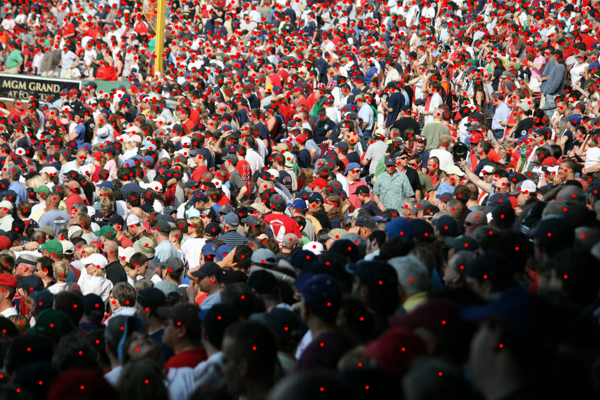

Shangai Groundtruth - Part: A, Split: train, Image index: 10, Image shape: (683, 1024, 3)


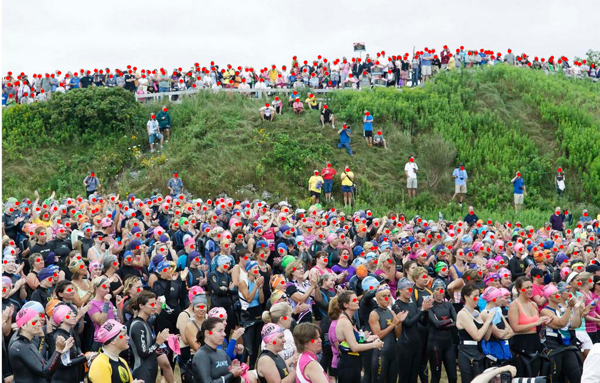

Shangai Groundtruth - Part: A, Split: train, Image index: 100, Image shape: (654, 1024, 3)


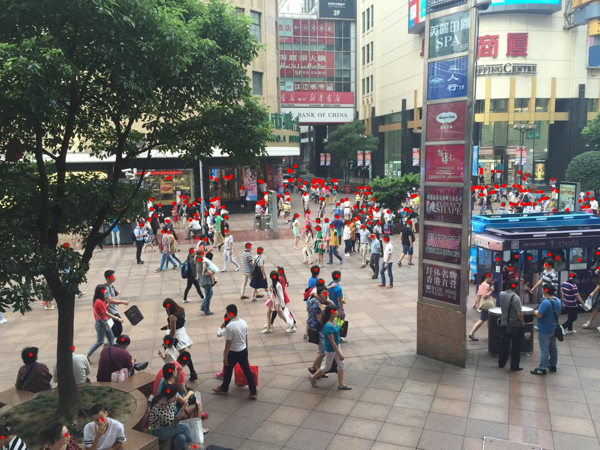

Shangai Groundtruth - Part: B, Split: train, Image index: 100, Image shape: (768, 1024, 3)


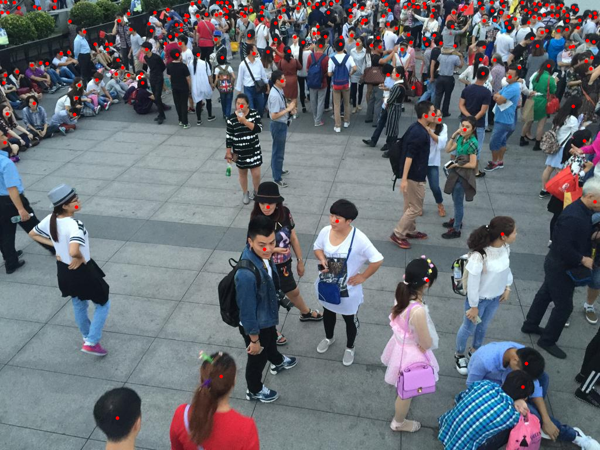

Shangai Groundtruth - Part: B, Split: train, Image index: 10, Image shape: (768, 1024, 3)


In [ ]:
plot_shanghai_groundtruth('A',10)
plot_shanghai_groundtruth('A',100)
plot_shanghai_groundtruth('B',100)
plot_shanghai_groundtruth('B',10)

## Histogram

In [ ]:
def plot_historgram(title, count):
  plt.hist(x=count, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
  plt.grid(axis='y', alpha=0.75)
  plt.xlabel('Count')
  plt.ylabel('Number of Images')
  plt.title(title)
  plt.show()

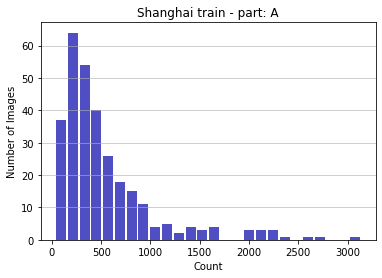

Mean: 542.3566666666667, Median: 378.0, Max: 3139, Min: 33
{'datasets/shanghai/part_A_final/train_data/ground_truth/GT_IMG_213.mat': 249, 'datasets/shanghai/part_A_final/train_data/ground_truth/GT_IMG_212.mat': 338, 'datasets/shanghai/part_A_final/train_data/ground_truth/GT_IMG_211.mat': 188, 'datasets/shanghai/part_A_final/train_data/ground_truth/GT_IMG_210.mat': 750, 'datasets/shanghai/part_A_final/train_data/ground_truth/GT_IMG_21.mat': 257, 'datasets/shanghai/part_A_final/train_data/ground_truth/GT_IMG_209.mat': 546, 'datasets/shanghai/part_A_final/train_data/ground_truth/GT_IMG_208.mat': 536, 'datasets/shanghai/part_A_final/train_data/ground_truth/GT_IMG_207.mat': 131, 'datasets/shanghai/part_A_final/train_data/ground_truth/GT_IMG_206.mat': 311, 'datasets/shanghai/part_A_final/train_data/ground_truth/GT_IMG_205.mat': 137, 'datasets/shanghai/part_A_final/train_data/ground_truth/GT_IMG_204.mat': 549, 'datasets/shanghai/part_A_final/train_data/ground_truth/GT_IMG_203.mat': 1957, 'dat

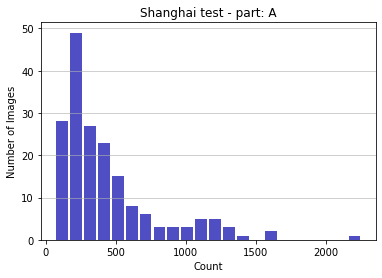

Mean: 433.9010989010989, Median: 307.5, Max: 2256, Min: 66
{'datasets/shanghai/part_A_final/test_data/ground_truth/GT_IMG_5.mat': 819, 'datasets/shanghai/part_A_final/test_data/ground_truth/GT_IMG_49.mat': 514, 'datasets/shanghai/part_A_final/test_data/ground_truth/GT_IMG_48.mat': 384, 'datasets/shanghai/part_A_final/test_data/ground_truth/GT_IMG_47.mat': 316, 'datasets/shanghai/part_A_final/test_data/ground_truth/GT_IMG_46.mat': 382, 'datasets/shanghai/part_A_final/test_data/ground_truth/GT_IMG_45.mat': 139, 'datasets/shanghai/part_A_final/test_data/ground_truth/GT_IMG_44.mat': 366, 'datasets/shanghai/part_A_final/test_data/ground_truth/GT_IMG_43.mat': 118, 'datasets/shanghai/part_A_final/test_data/ground_truth/GT_IMG_42.mat': 802, 'datasets/shanghai/part_A_final/test_data/ground_truth/GT_IMG_41.mat': 250, 'datasets/shanghai/part_A_final/test_data/ground_truth/GT_IMG_40.mat': 236, 'datasets/shanghai/part_A_final/test_data/ground_truth/GT_IMG_4.mat': 170, 'datasets/shanghai/part_A_fina

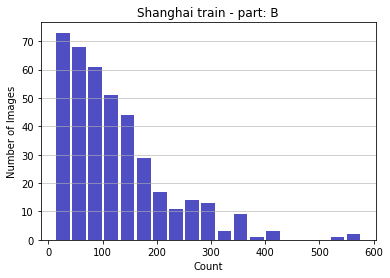

Mean: 123.2, Median: 99.5, Max: 578, Min: 12
{'datasets/shanghai/part_B_final/train_data/ground_truth/GT_IMG_213.mat': 36, 'datasets/shanghai/part_B_final/train_data/ground_truth/GT_IMG_212.mat': 111, 'datasets/shanghai/part_B_final/train_data/ground_truth/GT_IMG_211.mat': 34, 'datasets/shanghai/part_B_final/train_data/ground_truth/GT_IMG_210.mat': 165, 'datasets/shanghai/part_B_final/train_data/ground_truth/GT_IMG_21.mat': 152, 'datasets/shanghai/part_B_final/train_data/ground_truth/GT_IMG_209.mat': 74, 'datasets/shanghai/part_B_final/train_data/ground_truth/GT_IMG_208.mat': 168, 'datasets/shanghai/part_B_final/train_data/ground_truth/GT_IMG_207.mat': 188, 'datasets/shanghai/part_B_final/train_data/ground_truth/GT_IMG_206.mat': 47, 'datasets/shanghai/part_B_final/train_data/ground_truth/GT_IMG_205.mat': 103, 'datasets/shanghai/part_B_final/train_data/ground_truth/GT_IMG_204.mat': 95, 'datasets/shanghai/part_B_final/train_data/ground_truth/GT_IMG_203.mat': 344, 'datasets/shanghai/part_

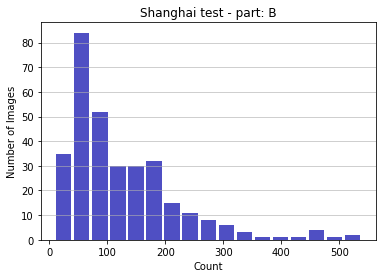

Mean: 124.07594936708861, Median: 93.0, Max: 539, Min: 9
{'datasets/shanghai/part_B_final/test_data/ground_truth/GT_IMG_213.mat': 284, 'datasets/shanghai/part_B_final/test_data/ground_truth/GT_IMG_212.mat': 139, 'datasets/shanghai/part_B_final/test_data/ground_truth/GT_IMG_211.mat': 51, 'datasets/shanghai/part_B_final/test_data/ground_truth/GT_IMG_210.mat': 35, 'datasets/shanghai/part_B_final/test_data/ground_truth/GT_IMG_21.mat': 89, 'datasets/shanghai/part_B_final/test_data/ground_truth/GT_IMG_209.mat': 149, 'datasets/shanghai/part_B_final/test_data/ground_truth/GT_IMG_208.mat': 73, 'datasets/shanghai/part_B_final/test_data/ground_truth/GT_IMG_207.mat': 106, 'datasets/shanghai/part_B_final/test_data/ground_truth/GT_IMG_206.mat': 89, 'datasets/shanghai/part_B_final/test_data/ground_truth/GT_IMG_205.mat': 57, 'datasets/shanghai/part_B_final/test_data/ground_truth/GT_IMG_204.mat': 148, 'datasets/shanghai/part_B_final/test_data/ground_truth/GT_IMG_203.mat': 187, 'datasets/shanghai/part_B

In [ ]:
# Plots shanghai histogram and save counts
PATHS_DIR = 'data/statistics'
  
if not os.path.exists(PATHS_DIR):
    os.makedirs(PATHS_DIR)

def plot_shanghai_histogram(part, is_train=True):
  data_type = "train" if is_train else "test" 
  groundtruth_path = f'datasets/shanghai/part_{part}_final/{data_type}_data/ground_truth'
  groundtruth_files = [f for f in listdir(groundtruth_path) if isfile(join(groundtruth_path, f))]
  counts = {}
  for file in groundtruth_files:
    groundtruth_current_path = f'datasets/shanghai/part_{part}_final/{data_type}_data/ground_truth/{file}'
    groundtruth_mat = loadmat(groundtruth_current_path)
    groundtruth = groundtruth_mat['image_info'][0, 0][0, 0][0].astype(np.uint32)
    counts[groundtruth_current_path] = len(groundtruth)
  plot_historgram(f"Shanghai {data_type} - part: {part}",list(counts.values()))
  print(f'Mean: {statistics.mean(counts.values())}, Median: {statistics.median(counts.values())}, Max: {max(counts.values())}, Min: {min(counts.values())}')
  with open(os.path.join(PATHS_DIR, f'shanghai_counts_{part}_{data_type}.json'), 'w') as outfile:
        json.dump(counts, outfile)
  print(counts)

plot_shanghai_histogram('A')
plot_shanghai_histogram('A', is_train=False)
plot_shanghai_histogram('B')
plot_shanghai_histogram('B', is_train=False)

# Preprocessing

## Generating json file paths

The files can be used by the train script in order to select data for training model.

In [ ]:
# Part A train path
PATHS_DIR = 'data/paths'
  
if not os.path.exists(PATHS_DIR):
    os.makedirs(PATHS_DIR)

In [ ]:
# Add shanghai file paths formated as: 'shanghai_{part}_{data_type}.json'

def create_shanghai_path_files():
  for part in ['A','B']:
    for data_type in ['train','test']:
      image_path = f'datasets/shanghai/part_{part}_final/{data_type}_data/images'
      files = [join(image_path,f) for f in listdir(image_path) if isfile(join(image_path, f))]
      with open(os.path.join(PATHS_DIR, f'shanghai_{part}_{data_type}.json'), 'w') as outfile:
        json.dump(files, outfile)

create_shanghai_path_files()

## Creating density maps

In the first step we will create density maps using the ground truth provided. The maps will be used as the ground truth when training our model. The generation proccess is done by using a gaussian filter to labaled entity in image.

In [ ]:
!python preprocessing/generate_shanghai_densities.py datasets/shanghai/

INFO:root:Generating part A density map
INFO:root:Processed 0 images out of 300
INFO:root:Processed 1 images out of 300
INFO:root:Processed 2 images out of 300
INFO:root:Processed 3 images out of 300
INFO:root:Processed 4 images out of 300
INFO:root:Processed 5 images out of 300
INFO:root:Processed 6 images out of 300
INFO:root:Processed 7 images out of 300
INFO:root:Processed 8 images out of 300
INFO:root:Processed 9 images out of 300
INFO:root:Processed 10 images out of 300
INFO:root:Processed 11 images out of 300
INFO:root:Processed 12 images out of 300
INFO:root:Processed 13 images out of 300
INFO:root:Processed 14 images out of 300
INFO:root:Processed 15 images out of 300
INFO:root:Processed 16 images out of 300
INFO:root:Processed 17 images out of 300
INFO:root:Processed 18 images out of 300
INFO:root:Processed 19 images out of 300
INFO:root:Processed 20 images out of 300
INFO:root:Processed 21 images out of 300
INFO:root:Processed 22 images out of 300
INFO:root:Processed 23 imag

Now lets see the results:

In [ ]:
from matplotlib import cm as CM

def plot_density_map(density_map):
  plt.axis('off')
  plt.imshow(density_map, cmap = CM.jet, interpolation = 'sinc', vmin = 0, vmax = 0.1)
  plt.show()

def plot_shanghai_density_map(part, split, image_index):
  plot_shanghai_groundtruth(part, image_index, max_size=350, split=split)
  target_path = f'datasets/shanghai/part_{part}_final/{split}_data/densities/IMG_{image_index}.h5'
  target_file = h5py.File(target_path, 'r')
  density_map = np.array(target_file['density'])
  plot_density_map(density_map)
  print(f'Shangai Density - Part: {part}, Split: {split}, Image index: {image_index}')

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192


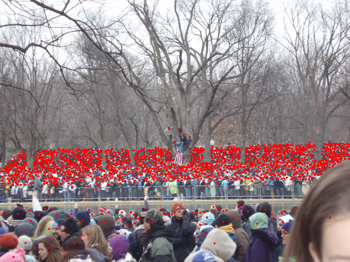

Shangai Groundtruth - Part: A, Split: train, Image index: 1, Image shape: (768, 1024, 3)


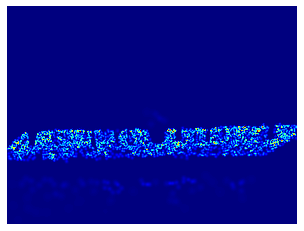

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192


Shangai Density - Part: A, Split: train, Image index: 1


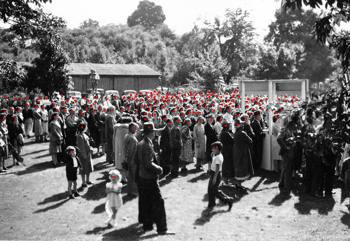

Shangai Groundtruth - Part: A, Split: test, Image index: 1, Image shape: (704, 1024, 3)


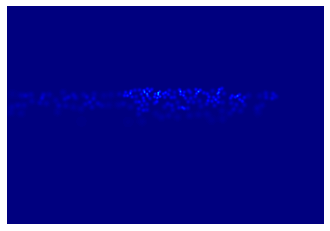

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192


Shangai Density - Part: A, Split: test, Image index: 1


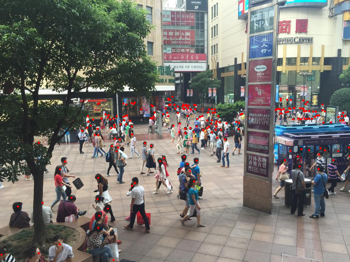

Shangai Groundtruth - Part: B, Split: train, Image index: 100, Image shape: (768, 1024, 3)


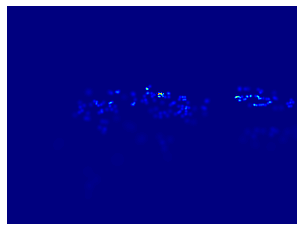

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192


Shangai Density - Part: B, Split: train, Image index: 100


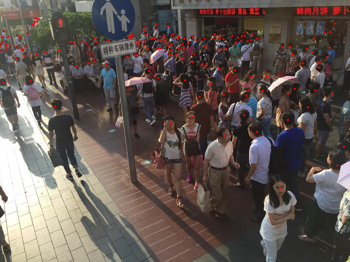

Shangai Groundtruth - Part: B, Split: test, Image index: 100, Image shape: (768, 1024, 3)


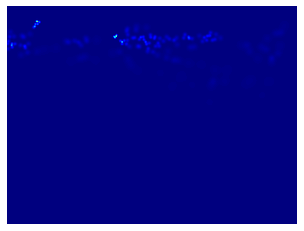

Shangai Density - Part: B, Split: test, Image index: 100


In [ ]:
plot_shanghai_density_map('A','train','1')
plot_shanghai_density_map('A','test','1')
plot_shanghai_density_map('B','train','100')
plot_shanghai_density_map('B','test','100')

# Training

The model topology as described in CSRNet uses VGG16 as frontend where the fully connected layer is replaced by convolution layers with dialation:

In [ ]:
from torchvision import models
a = models.vgg19(pretrained=True)
print(a)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
!python model.py

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

For the training model I'll use MSE Loss and LR of 1e-6 as described.
The training itself can be done by using train.py supplying train/test path json files.

In [ ]:
!python train.py vanilla data/paths/shanghai_A_train.json data/paths/shanghai_A_test.json

2021-02-24:22:14:51 INFO [train.py:65] Saving metadata: {'learning_rate': 1e-06, 'momentum': 0.95, 'decay': 0.0005, 'augmentation_type': None, 'reduction': 'sum'} in data/train/metadata_data_vanilla.json
2021-02-24:22:14:51 INFO [train.py:74] Using device: cuda:0 for training
2021-02-24:22:14:51 INFO [train.py:77] Building model
2021-02-24:22:14:55 INFO [train.py:104] Training
/content/drive/My Drive/Studies/IDC/DL/Final Project/Code/augmentation.py:34: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  target_file = h5py.File(target_path)
2021-02-24:22:14:56 INFO [train.py:173] Epoch [1/200] (0/300) Avg loss = 234.119
2021-02-24:22:15:12 INFO [train.py:173] Epoch [1/200] (50/300) Avg loss

In [ ]:
!python train.py vanilla_using_mean_loss data/paths/shanghai_A_train.json data/paths/shanghai_A_test.json

2021-02-26:07:50:59 INFO [train.py:65] Saving metadata: {'learning_rate': 1e-06, 'momentum': 0.95, 'decay': 0.0005, 'augmentation_type': None, 'reduction': 'mean'} in data/train/metadata_data_vanilla_using_mean_loss.json
2021-02-26:07:50:59 INFO [train.py:74] Using device: cuda:0 for training
2021-02-26:07:50:59 INFO [train.py:77] Building model
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:06<00:00, 88.6MB/s]
2021-02-26:07:51:17 INFO [train.py:104] Training
/content/drive/My Drive/Studies/IDC/DL/Final Project/Code/augmentation.py:34: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  target

In [ ]:
!python train.py vanilla_using_mean_loss_lr_0_1 -p data/ckpt/temp_model_vanilla_using_mean_loss.pth.tar data/paths/shanghai_A_train.json data/paths/shanghai_A_test.json

2021-02-26:10:16:57 INFO [train.py:59] Using device: cuda:0 for training
2021-02-26:10:16:57 INFO [train.py:62] Building model
2021-02-26:10:17:01 INFO [train.py:69] Loading checkpoint from data/ckpt/temp_model_vanilla_using_mean_loss.pth.tar
2021-02-26:10:17:01 INFO [train.py:72] Continue training at epoch 53
2021-02-26:10:17:01 INFO [train.py:93] Saving metadata: {'learning_rate': 0.1, 'momentum': 0.95, 'decay': 0, 'augmentation_type': None, 'reduction': 'mean', 'start_epoch': 53, 'pretrained': 'data/ckpt/temp_model_vanilla_using_mean_loss.pth.tar'} in data/train/metadata_data_vanilla_using_mean_loss_lr_0_1.json
2021-02-26:10:17:01 INFO [train.py:106] Training
/content/drive/MyDrive/Studies/IDC/DL/Final Project/Code/augmentation.py:34: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY

In [ ]:
!python train.py multi_crop -at multi_crop data/paths/shanghai_A_train.json data/paths/shanghai_A_test.json

2021-02-27:09:01:45 INFO [train.py:57] Using device: cuda:0 for training
2021-02-27:09:01:45 INFO [train.py:60] Building model
2021-02-27:09:01:49 INFO [train.py:76] Performing train augmentation of type multi_crop
2021-02-27:09:01:49 INFO [train.py:92] Saving metadata: {'learning_rate': 1e-06, 'momentum': 0.95, 'decay': 0.0005, 'augmentation_type': 'multi_crop', 'reduction': 'sum', 'start_epoch': 1, 'pretrained': None} in data/train/metadata_data_multi_crop.json
2021-02-27:09:01:49 INFO [train.py:105] Training
/content/drive/MyDrive/Studies/IDC/DL/Final Project/Code/augmentation.py:34: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  target_file = h5py.File(target_path)
2021-02-27:09:01

In [ ]:
!python train.py -vgg19 vgg_19 data/paths/shanghai_A_train.json data/paths/shanghai_A_test.json

2021-03-01:09:50:52 INFO [train.py:58] Using device: cuda:0 for training
2021-03-01:09:50:52 INFO [train.py:61] Building model
2021-03-01:09:50:52 INFO [train.py:63] Building VGG19
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100% 548M/548M [00:06<00:00, 89.6MB/s]
2021-03-01:09:51:11 INFO [train.py:110] Training
/content/drive/MyDrive/Studies/IDC/DL/Final Project/Code/augmentation.py:34: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  target_file = h5py.File(target_path)
2021-03-01:09:51:40 INFO [train.py:177] Epoch [1/200] (0/300) Avg loss = 2269.725
2021-03-01:09:52:38 INFO [train.py:177] Epoch [1/200] (

# Evaluation

We can now plot the loss graphs to check our train process. I will also evaluate each one of the diffent models and get some visual impression.

In [ ]:
# Plots the loss and MAE of of the training proccess
def plot_graph(name, result_path, plot=None, window_length = 31):
  with open(result_path) as f:
    data = json.load(f)
  epochs = range(1,len(data['train_loss'])+1)
  if plot is None or plot == 'LOSS':
    loss_train = data['train_loss']
    test_loss = data['test_loss']
    smooth_test_loss = savgol_filter(test_loss, window_length, 3)
    plt.plot(epochs, loss_train, label='Train loss')
    plt.plot(epochs, test_loss, label='Test loss')
    # plt.plot(epochs, smooth_test_loss, label='Test loss trend')
    if plot is not None:
      plt.ylabel('Loss')
  if plot is None or plot == 'MAE':
    test_mae = data['test_mae']
    # plt.plot(epochs, test_mae , label='Test MAE')
    smooth_test_mae = savgol_filter(test_mae, window_length, 3)
    plt.plot(epochs, smooth_test_mae , label='Test MAE trend')
    if plot is not None:
      plt.ylabel('MAE')
  plt.title(name)
  plt.xlabel('Epoch')
  if plot is None:
    plt.ylabel('Loss/MAE')
  plt.legend()
  plt.show()
  plot_times(name, data)

# Plots training times
def plot_times(name, data):
  number_of_epochs = len(data['train_time'])
  epochs = range(1,number_of_epochs+1)
  train_time = data['train_time']
  evaluation_time = data['evaluation_time']
  total_time = data['total_time']
  plt.plot(epochs, train_time, label='Train time')
  plt.plot(epochs, evaluation_time, label='Evaluation time')
  plt.plot(epochs, total_time, label='Total time')
  plt.title(f'Time measurement: {name}')
  plt.xlabel('Epoch')
  plt.ylabel('Time (sec)')
  plt.legend()
  plt.show()
  print(f'Total training time: {sum(train_time)} (sec)')
  print(f'Total evaluation time: {sum(train_time)} (sec)')
  print(f'Total time: {sum(total_time)} (sec)')
  print(f'Number of epochs: {number_of_epochs}')

## Vanilla implementation

I have created a vanilla CSRNet and would like to see if I can reach good results. I have used LR of 1e-6 as described in the paper and added decay of 5e-4 and momentum of 0.95. I have run this network for 140 epochs.

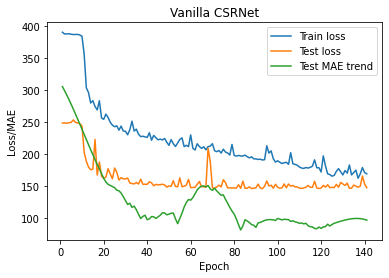

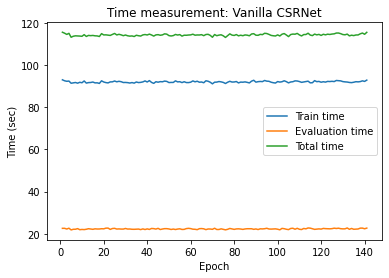

Total training time: 12981.70937037468 (sec)
Total evaluation time: 12981.70937037468 (sec)
Total time: 16125.790491819382 (sec)
Number of epochs: 141


In [ ]:
plot_graph('Vanilla CSRNet', 'data/train/epoch_data_vanilla.json')

Now we can evaluate the model using evaulation.py.


In [ ]:
!python evaluation.py data/ckpt/best_pred_model_vanilla.pth.tar data/paths/shanghai_A_test.json

2021-02-28:13:42:32 INFO [evaluation.py:31] Evaluating using cuda:0 device
2021-02-28:13:42:32 INFO [evaluation.py:37] Evaluating on 182 images
2021-02-28:13:42:32 INFO [evaluation.py:40] Building model
2021-02-28:13:42:34 INFO [evaluation.py:47] Starting evaluation
/content/drive/MyDrive/Studies/IDC/DL/Final Project/Code/augmentation.py:34: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  target_file = h5py.File(target_path)
evaluation.py:65: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  instance_ssim = ssim(ssim_target, ssim_output)
2021-02-28:13:42:35 INFO [evalu

I was able to reach MAE of ~72 which is pretty close to the MAE showm in the paper. This means that on average the network varies from the groundtruth count by 72. Moreover, the RMSE I have 
reaches is even better than the one mentioned.

Lets visualize network output.

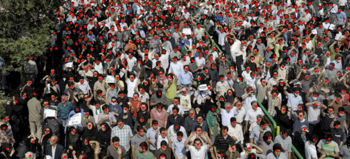

Shangai Groundtruth - Part: A, Split: test, Image index: 100, Image shape: (409, 902, 3)


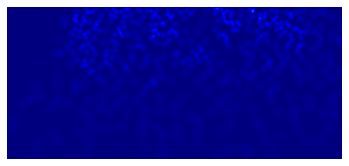

Shangai Density - Part: A, Split: test, Image index: 100
Model: best_pred_model_vanilla, Count: 378.586181640625, Image: datasets/shanghai/part_A_final/test_data/images/IMG_100.jpg


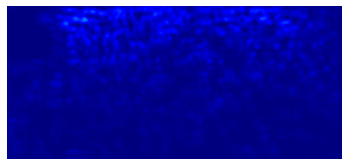

Groundtruth count 391


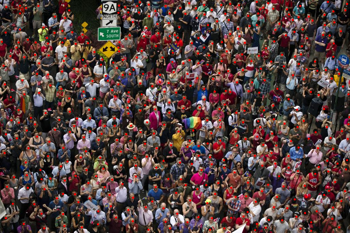

Shangai Groundtruth - Part: A, Split: test, Image index: 20, Image shape: (683, 1024, 3)


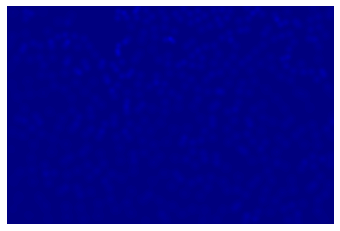

Shangai Density - Part: A, Split: test, Image index: 20
Model: best_pred_model_vanilla, Count: 450.70574951171875, Image: datasets/shanghai/part_A_final/test_data/images/IMG_20.jpg


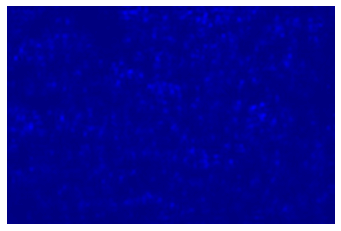

Groundtruth count 460


In [ ]:
plot_shanghai_density_map('A','test','100')
with open('data/statistics/shanghai_counts_A_test.json') as infile:
  counts = json.load(infile)
print('Groundtruth count',counts['datasets/shanghai/part_A_final/test_data/ground_truth/GT_IMG_100.mat'] )
print("Model Output")
%run run_model.py data/ckpt/best_pred_model_vanilla.pth.tar datasets/shanghai/part_A_final/test_data/images/IMG_100.jpg


plot_shanghai_density_map('A','test','20')
with open('data/statistics/shanghai_counts_A_test.json') as infile:
  counts = json.load(infile)
print('Groundtruth count',counts['datasets/shanghai/part_A_final/test_data/ground_truth/GT_IMG_20.mat'] )
print("Model Output")
%run run_model.py data/ckpt/best_pred_model_vanilla.pth.tar datasets/shanghai/part_A_final/test_data/images/IMG_20.jpg


Now, I was interested to know if there is any difference in accuaracy resulting the density of the crowd.

In [ ]:
#Genreate json file containing model     counts for all test images of part A
!python count.py -a data/ckpt/best_pred_model_vanilla.pth.tar data/paths/shanghai_A_test.json

INFO:root:Counting using cuda:0 device
INFO:root:Image: datasets/shanghai/part_A_final/test_data/images/IMG_5.jpg, Count:603.8604125976562
INFO:root:Image: datasets/shanghai/part_A_final/test_data/images/IMG_49.jpg, Count:484.498046875
INFO:root:Image: datasets/shanghai/part_A_final/test_data/images/IMG_48.jpg, Count:375.8263244628906
INFO:root:Image: datasets/shanghai/part_A_final/test_data/images/IMG_47.jpg, Count:433.03594970703125
INFO:root:Image: datasets/shanghai/part_A_final/test_data/images/IMG_46.jpg, Count:437.6799011230469
INFO:root:Image: datasets/shanghai/part_A_final/test_data/images/IMG_45.jpg, Count:89.3474349975586
INFO:root:Image: datasets/shanghai/part_A_final/test_data/images/IMG_44.jpg, Count:358.8862609863281
INFO:root:Image: datasets/shanghai/part_A_final/test_data/images/IMG_43.jpg, Count:123.13983154296875
INFO:root:Image: datasets/shanghai/part_A_final/test_data/images/IMG_42.jpg, Count:842.9757080078125
INFO:root:Image: datasets/shanghai/part_A_final/test_dat

OrderedDict([(6, [0, 0.7035772351251133]), (7, [0.6568044026692708]), (8, [0.724580143274886, 0.8197447311046512]), (9, [0.9475340484290995, 0.8792778093790271]), (10, [0.7826040679333257, 0.9133652035552676]), (11, [0.9564421055680614, 0.9830526624407087, 0.946465135657269]), (12, [0.8152193764383479, 0.7476416693793403, 0.9099532198314825, 0.6874016933753841]), (13, [0.6427873021407093, 0.9786844740818886, 0.9255545479910714, 0.7723817048249422]), (14, [0.5829333582668439, 0.8687201378329488]), (15, [0.7765294492634294, 0.7298680202216858, 0.93416590472452]), (16, [0.5976577570408951, 0.6165346087831439, 0.6535377733635179, 0.725804432328925]), (17, [0.8889551499310662, 0, 0.9628172787753019]), (18, [0.9961961180299193, 0.7211697486139113]), (19, [0.5552570187315649, 0.9593826685196314, 0.96456073396769, 0.9029509577918892, 0.8939719655405935, 0.6756803813733553, 0.6630856196085613, 0.7122081697295984, 0.8616196603486033]), (20, [0.7681578856248121, 0.8985032528494867]), (21, [0.8188

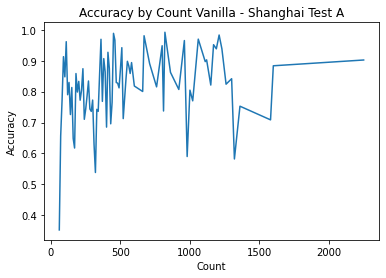

In [ ]:
def get_image_index(path):
   _, name = os.path.split(path)
   name = name.split('.')[0]
   return int(name.split('_')[-1])

with open('data/statistics/shanghai_best_pred_model_vanilla_output_counts.json') as infile:
  count_output = json.load(infile)
with open('data/statistics/shanghai_counts_A_test.json') as infile:
  count_groundtruth = json.load(infile)

count_output_by_index = {}
count_groundtruth_by_index = {} 
for k, v in count_output.items():
  count_output_by_index[get_image_index(k)] = v
for k, v in count_groundtruth.items():
  count_groundtruth_by_index[get_image_index(k)] = v

accuracy_results = {}
for k in count_output_by_index.keys():
  output_value = count_output_by_index[k]
  groundtruth_value = count_groundtruth_by_index[k]
  accuracy = max(0,1 - (abs(output_value-groundtruth_value)/groundtruth_value))
  try:
    accuracy_results[groundtruth_value//10].append(accuracy)
  except:
    accuracy_results[groundtruth_value//10] = [accuracy]

accuracy_results = collections.OrderedDict(sorted(accuracy_results.items()))
print(accuracy_results)
accuracy_results_mean = {}
for k, v in accuracy_results.items():
  accuracy_results_mean[k*10] = np.mean(v)
counts = list(accuracy_results_mean.keys())
x = [str(i-10)+'-'+str(i) for i in counts]
accuracy = list(accuracy_results_mean.values())
smooth_test_loss = savgol_filter(accuracy, 21, 3)
plt.plot(counts, accuracy)
# plt.plot(counts, smooth_test_loss)
plt.title(f'Accuracy by Count Vanilla - Shanghai Test A')
plt.xlabel('Count')
plt.ylabel('Accuracy')
# plt.legend()
plt.show()

## Using MSELoss with Mean instead of sum

The original method uses MSELoss uses sum operation. I wanted to check if changing the loss function using mean might increase accuaracy as the input images are in different sizes what can affect the training proccess.

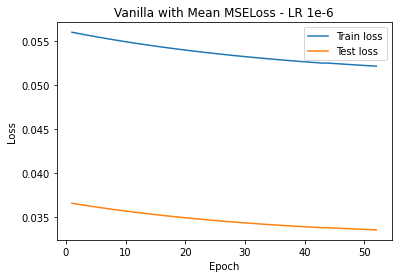

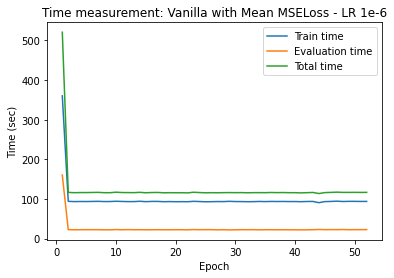

Total training time: 5134.25315284729 (sec)
Total evaluation time: 5134.25315284729 (sec)
Total time: 6444.4769830703735 (sec)
Number of epochs: 52


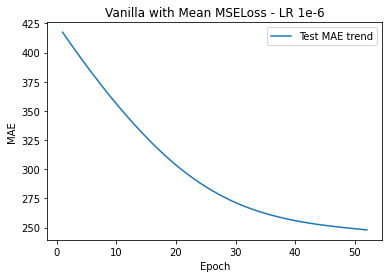

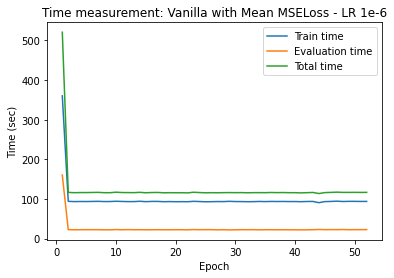

Total training time: 5134.25315284729 (sec)
Total evaluation time: 5134.25315284729 (sec)
Total time: 6444.4769830703735 (sec)
Number of epochs: 52


In [ ]:
plot_graph('Vanilla with Mean MSELoss - LR 1e-6', 'data/train/epoch_data_vanilla_using_mean_loss.json', plot='LOSS')
plot_graph('Vanilla with Mean MSELoss - LR 1e-6', 'data/train/epoch_data_vanilla_using_mean_loss.json', plot='MAE')

I have noticed that MAE is less prone to flactuation but the network does not learn as well as the MAE converges to a much higher values (~250). I wanted to check if this isn't caused due to low LR or decay so I have continued training this network with differnt parameters for another 25 epochs but results remain the same.

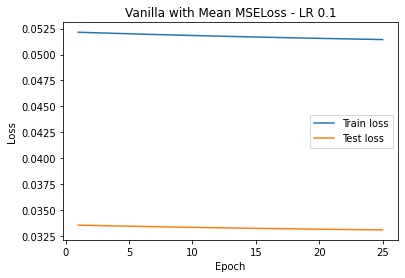

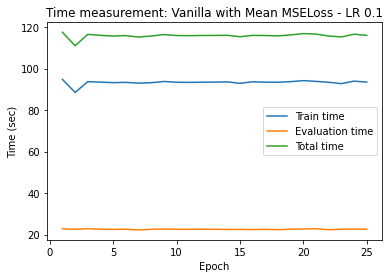

Total training time: 2333.1407446861267 (sec)
Total evaluation time: 2333.1407446861267 (sec)
Total time: 2896.34530210495 (sec)
Number of epochs: 25


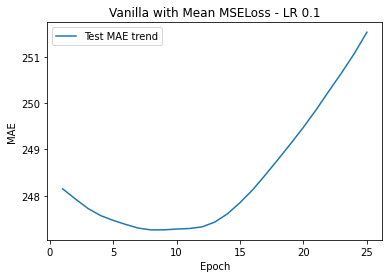

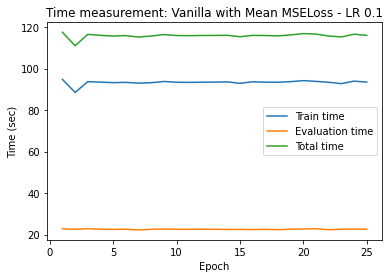

Total training time: 2333.1407446861267 (sec)
Total evaluation time: 2333.1407446861267 (sec)
Total time: 2896.34530210495 (sec)
Number of epochs: 25


In [ ]:
plot_graph('Vanilla with Mean MSELoss - LR 0.1', 'data/train/epoch_data_vanilla_using_mean_loss_lr_0_1.json', plot='LOSS', window_length = 5)
plot_graph('Vanilla with Mean MSELoss - LR 0.1', 'data/train/epoch_data_vanilla_using_mean_loss_lr_0_1.json', plot='MAE', window_length = 5)

The MAE started to increase and the loss change is minimal. 

## Adding Image Augmentation

I would like to check if data augmentation might give better results. Therefore, I had to create a custom augmentation function as images with different sizes cunnot be batched together.

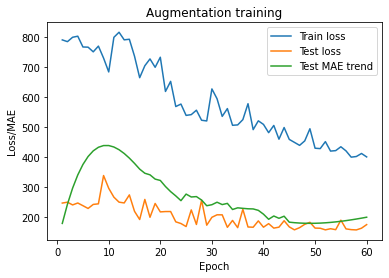

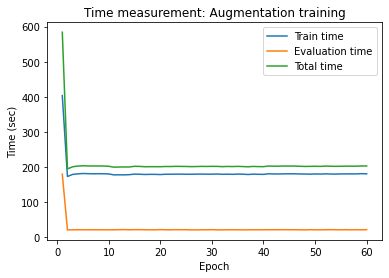

Total training time: 11037.159792661667 (sec)
Total evaluation time: 11037.159792661667 (sec)
Total time: 12514.081696510315 (sec)
Number of epochs: 60


In [ ]:
plot_graph('Augmentation training', 'data/train/epoch_data_multi_crop.json')

## Using VGG19

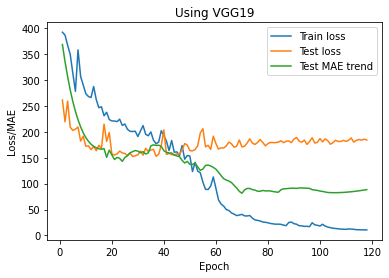

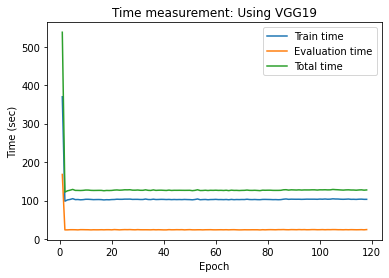

Total training time: 12405.346272468567 (sec)
Total evaluation time: 12405.346272468567 (sec)
Total time: 15383.396235466003 (sec)
Number of epochs: 118


In [ ]:
plot_graph('Using VGG19', 'data/train/epoch_data_vgg_19.json')


In [ ]:
!python evaluation.py data/ckpt/best_pred_model_vgg_19.pth.tar -vgg19 data/paths/shanghai_A_test.json

2021-03-01:15:00:48 INFO [evaluation.py:32] Evaluating using cuda:0 device
2021-03-01:15:00:48 INFO [evaluation.py:38] Evaluating on 182 images
2021-03-01:15:00:48 INFO [evaluation.py:41] Building model
2021-03-01:15:00:51 INFO [evaluation.py:44] Building VGG19
2021-03-01:15:00:51 INFO [evaluation.py:52] Starting evaluation
/content/drive/MyDrive/Studies/IDC/DL/Final Project/Code/augmentation.py:34: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  target_file = h5py.File(target_path)
evaluation.py:70: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  instance_ssim = ssi

## Ensemble

I would like to check if an ensemble might produce better results. First, I will run a simple check with Vanilla weight of 1.

In [ ]:
!python ensemble.py data/ckpt/best_pred_model_vanilla.pth.tar data/ckpt/best_pred_model_vgg_19.pth.tar data/paths/shanghai_A_test.json 1

2021-03-02:18:55:30 INFO [ensemble.py:22] Evaluating using cuda:0 device
2021-03-02:18:55:30 INFO [ensemble.py:28] Evaluating on 182 images
2021-03-02:18:55:30 INFO [ensemble.py:31] Building model
2021-03-02:18:55:34 INFO [ensemble.py:44] Starting evaluation
/content/drive/MyDrive/Studies/IDC/DL/Final Project/Code/augmentation.py:34: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  target_file = h5py.File(target_path)
ensemble.py:65: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  instance_ssim = ssim(ssim_target, ssim_output)
2021-03-02:18:55:53 INFO [ensemble.py:78]

The 90% vanilla enseble gave better results but still very close to the vanilla run without ensemble. {'mae': 71.61183302743095, 'rmse': 108.81782636057326, 'ssim': 0.7603246529381238}

In [ ]:
!python ensemble.py data/ckpt/best_pred_model_vanilla.pth.tar data/ckpt/best_pred_model_vgg_19.pth.tar data/paths/shanghai_A_test.json 0.9

2021-03-02:19:00:23 INFO [ensemble.py:22] Evaluating using cuda:0 device
2021-03-02:19:00:23 INFO [ensemble.py:28] Evaluating on 182 images
2021-03-02:19:00:23 INFO [ensemble.py:31] Building model
2021-03-02:19:00:26 INFO [ensemble.py:44] Starting evaluation
/content/drive/MyDrive/Studies/IDC/DL/Final Project/Code/augmentation.py:34: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  target_file = h5py.File(target_path)
ensemble.py:65: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  instance_ssim = ssim(ssim_target, ssim_output)
2021-03-02:19:00:27 INFO [ensemble.py:78]

In [ ]:
!python ensemble.py data/ckpt/best_pred_model_vanilla.pth.tar data/ckpt/best_pred_model_vgg_19.pth.tar data/paths/shanghai_A_test.json 0.8

2021-03-02:19:13:34 INFO [ensemble.py:22] Evaluating using cuda:0 device
2021-03-02:19:13:34 INFO [ensemble.py:28] Evaluating on 182 images
2021-03-02:19:13:34 INFO [ensemble.py:31] Building model
2021-03-02:19:13:38 INFO [ensemble.py:44] Starting evaluation
/content/drive/MyDrive/Studies/IDC/DL/Final Project/Code/augmentation.py:34: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  target_file = h5py.File(target_path)
ensemble.py:65: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  instance_ssim = ssim(ssim_target, ssim_output)
2021-03-02:19:13:38 INFO [ensemble.py:78]

# Real world and fun experiments

In [ ]:
def print_image(image):
  img = Image.open(image)
  img.thumbnail((300, 300))
  display(img)

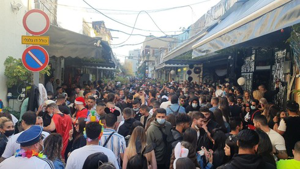

Model: best_pred_model_vanilla, Count: 160.9878692626953, Image: data/images/tel_aviv_party.jpg


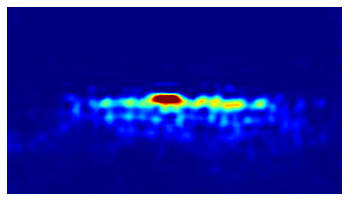

In [ ]:
print_image('data/images/tel_aviv_party.jpg')
%run run_model.py -i 2 data/ckpt/best_pred_model_vanilla.pth.tar data/images/tel_aviv_party.jpg

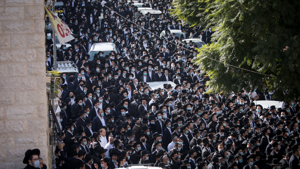

Model: best_pred_model_vanilla, Count: 421.46282958984375, Image: data/images/jerusalem.jpg


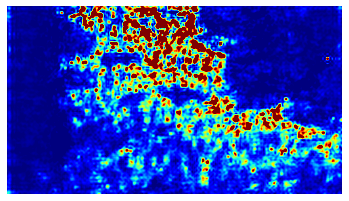

In [ ]:
print_image('data/images/jerusalem.jpg')
%run run_model.py -i 0.1 data/ckpt/best_pred_model_vanilla.pth.tar data/images/jerusalem.jpg

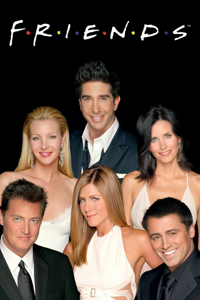

Model: best_pred_model_vanilla, Count: 35.89490509033203, Image: data/images/friends.jpg


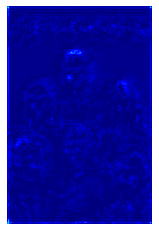

In [ ]:
print_image('data/images/friends.jpg')
%run run_model.py -i 0.1 data/ckpt/best_pred_model_vanilla.pth.tar data/images/friends.jpg

I expected the count here to be not accurate as I chose this image for a reason because the network did not train on portrait / very sparse images.

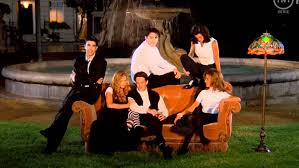

Model: best_pred_model_vanilla, Count: 7.506345748901367, Image: data/images/friends2.jpg


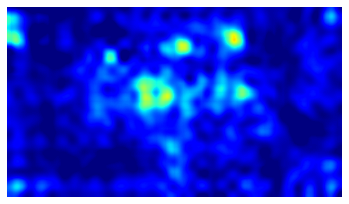

In [ ]:
print_image('data/images/friends2.jpg')
%run run_model.py -i 0.1 data/ckpt/best_pred_model_vanilla.pth.tar data/images/friends2.jpg